# Predicción de los gastos médicos de pacientes
---

Para este ejercicio utilizaremos los datos presentados en [este](https://www.kaggle.com/mirichoi0218/insurance) dataset de Kaggle en el cual se presentan datos de seguros médicos. 


## Descarga e instalación de librerías

Lo primero que se hará es descargar la librería **[regressors](https://pypi.org/project/regressors/)** que ayudará a hacer un análisis más profundo sobre la regresión lineal.

In [62]:
# Lo instalamos en nuestro ambiente local, en este caso trabajo en una ambiente de conda
# para instalarlo ejecutamos las siguientes lineas de codigo en el ambiente seleccionado:
#%pip install --upgrade pip setuptools==57.5.0
#%pip install regressors

In [63]:
# librerias
import pandas as pd
import seaborn as sns

In [64]:
# Estilos de las graficas
sns.set(style='whitegrid', context='notebook')

## Descargando los datos
Descarguemos los datos y veamos cómo se ven.

In [65]:
df = pd.read_csv('./insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Analizando los datos
Observamos cómo se distribuyen los datos de la variable a predecir.

In [66]:
# dimension del dataframe
print(df.shape)

(1338, 7)


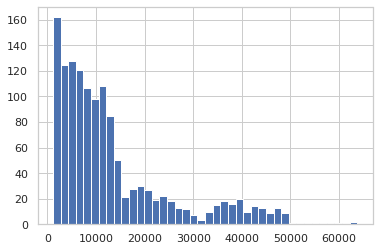

In [67]:
# Histograma de la variable objetivo (charges)
df.charges.hist(bins=40);

Algo que analizar, según este gráfico, es entender qué está pasando con los datos arriba de los 50,000. Parece haber muy pocos datos de este lado.

In [68]:
df[df.charges > 50000]

,age,sex,bmi,children,smoker,region,charges
34,28,male,36.400,1,yes,southwest,51194.55914
543,54,female,47.410,0,yes,southeast,63770.42801
577,31,female,38.095,1,yes,northeast,58571.07448
819,33,female,35.530,0,yes,northwest,55135.40209
1146,60,male,32.800,0,yes,southwest,52590.82939
1230,52,male,34.485,3,yes,northwest,60021.39897
1300,45,male,30.360,0,yes,southeast,62592.87309


En este caso, al ser pocos datos (6 de 1338), eliminaremos estos datos atípicos. A modo didáctico producen más ruido en la predicción que se está intentando hacer en este ejercicio. 

Sin embargo es importante aclarar que **NO SE DEBEN ELIMINAR** datos atípicos sin antes conocer a alguien que conozca o sea experto en los datos para que pueda guiarnos mejor sobre ellos.

In [69]:
# df con solo cargos menores a 50000
df = df[df.charges < 50000]

Vamos a crear una funcion que detecte valores atipicos de una variable especifica y devuelva un dataframe con el indice y los valores de los outliers 

In [112]:
def detect_outliers(x):
    
    Q3 = df[x].quantile(0.75)
    Q1 = df[x].quantile(0.25)
    IQR = Q3 - Q1
    
    superior = Q3 + (1.5 * IQR)
    inferior = Q3 - (1.5 * IQR)

    out_sup = df[df[x] > superior].index
    out_inf = df[df[x] < inferior].index

    outliers = {}
    for i in out_sup:
        outliers[i] = df.loc[i, x]
        
    for j in out_sup:
        outliers[i] = df.loc[j, x]
        
    size = len(outliers)
    
    df_outliers = pd.DataFrame(list(outliers.items()), columns=['Indice',x])
    return df_outliers
    

Probamos la funcion en la variable **bmi**

In [113]:
detect_outliers('bmi')

,Indice,bmi
0,116,49.06
1,286,48.07
2,401,47.52
3,847,50.38
4,860,47.60
5,1047,52.58
6,1088,47.74
7,1317,53.13


Verifiquemos que sean correctas los resultados de la funcion mediante el histograma de **bmi**

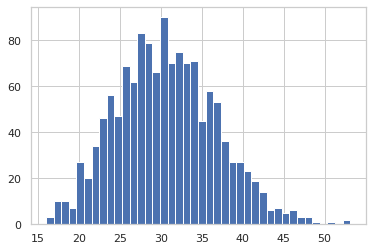

In [72]:
df.bmi.hist(bins=40);

Vemos que los valores de bmi mayores a 50 tienden a ser valores atipicos.

In [73]:
df[df['bmi'] > 50]

,age,sex,bmi,children,smoker,region,charges
847,23,male,50.38,1,no,southeast,2438.0552
1047,22,male,52.58,1,yes,southeast,44501.3982
1317,18,male,53.13,0,no,southeast,1163.4627


Observemos la distribucion edad

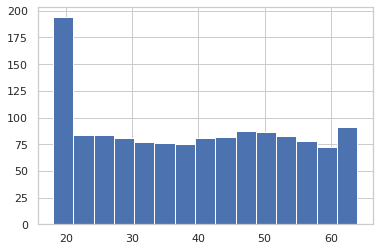

In [74]:
df.age.hist(bins=15);

Las edades estan distribuidas relativamente uniforme desde los 22 a los 60. Hay una gran cantidad de pacientes con edades entre los 18 y 21.

Observemos el histograma de los pacientes que fuman y no fuman

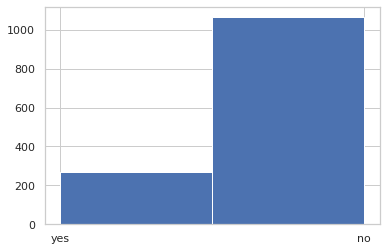

In [75]:
df.smoker.hist(bins=2);

La grafica nos indica que hay mas pacientes que no fuman de los que si fuman

## Viendo correlaciones
Ahora entendamos nuestros datos, viendo cómo se distribuyen y correlacionan. 

In [76]:
# importamos libreria
import matplotlib.pyplot as plt

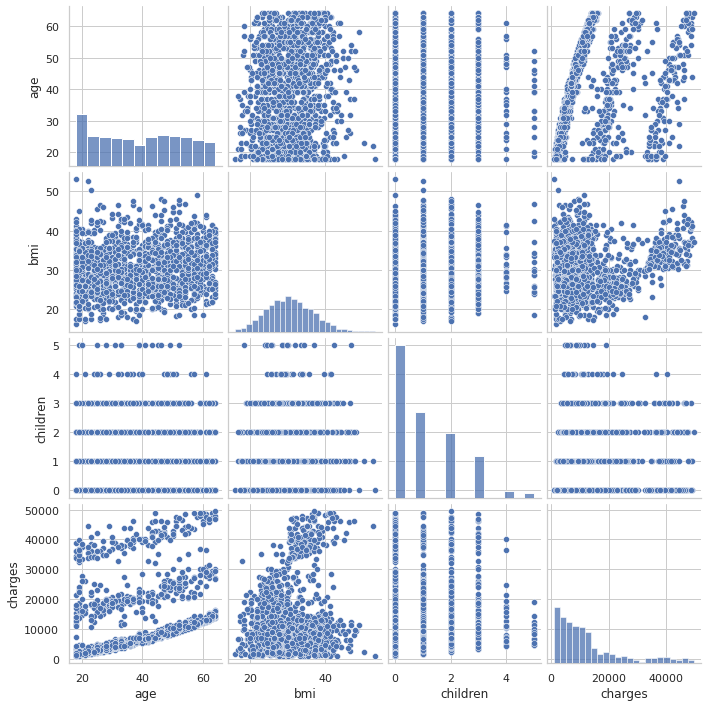

In [77]:
# creamos una matriz de graficos
sns.pairplot(df, height=2.5);

Puntos interesantes a ver:

- Hay 3 grupos de personas diferentes que se clasifican en edad / cargos, esto puede ser un punto a analizar después.

En general los valores se distribuyen de manera esperada. Con valores extremos en el caso de los cargos, sin embargo esto es de esperarse pues los cargos en los hospitales pueden variar mucho por quedarse un día más en el hospital o incluso por procedimientos extras.

- Parece que los datos están limpios, la variable de índice de masa corporal se distribuye de manera normal o gausiana, lo cual sería esperado en un índice de este tipo.

Ahora, creamos un mapa de calor de las variables

In [78]:
import numpy as np

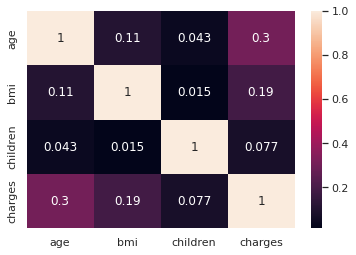

In [79]:
# agrupamos variables numericas
numeric_cols = ['age','bmi','children','charges']

# obtenemos los coeficientes de correlacion de las variables
cm = np.corrcoef(df[numeric_cols].values.T)

# Plot heat map
sns.heatmap(cm, annot=True, yticklabels=numeric_cols, xticklabels=numeric_cols);


## Utilizando las demás variables
Las demás variables son variables categoricas, sexo, fumador, región. Para poder utilizarlas utilizaremos la función get_dummies de pandas. 

Ahora la verás en acción

In [80]:
# pasamos las variables categoricas
pd.get_dummies(df, columns=['sex','smoker','region'])

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1,0,0,1,0,0,0,1
1,18,33.770,1,1725.55230,0,1,1,0,0,0,1,0
2,28,33.000,3,4449.46200,0,1,1,0,0,0,1,0
3,33,22.705,0,21984.47061,0,1,1,0,0,1,0,0
4,32,28.880,0,3866.85520,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,0,1,1,0,0,1,0,0
1334,18,31.920,0,2205.98080,1,0,1,0,1,0,0,0
1335,18,36.850,0,1629.83350,1,0,1,0,0,0,1,0
1336,21,25.800,0,2007.94500,1,0,1,0,0,0,0,1


In [81]:
# papa eliminar las variables redundantes utilizamos el parametro drop_first
df = pd.get_dummies(df, columns=['sex','smoker','region'], drop_first=True)
df.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0


## Primer modelo 
Primero se usará un modelo con todas las variables.

In [82]:
# librerias
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split # permite crear un dataset de prueba y de entrenamiento

In [83]:
# utiliza set para quitar las variables que no sean de interes

# variables predictoras 
X_cols = list(set(df.columns) - set(['charges']))

# variable objetivo
y_col = ['charges']

In [84]:
# definimos las variables a utilizar en el modelo

# Variables predictoras
X=df[X_cols].values

# Variable objetivo
y = df[y_col].values

In [85]:
# creamos dos conjuntos de datos: de prueba y de entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X,y)

# Estandarizamos los datos
sc_x = StandardScaler().fit(X)
sc_y = StandardScaler().fit(y)

X_train = sc_x.transform(X_train)
X_test = sc_x.transform(X_test)
y_train = sc_y.transform(y_train)
y_test = sc_y.transform(y_test)

In [86]:
# creamos el modelo
model = LinearRegression()

# ajustamos el modelos a los datos de entrenamiento
model.fit(X_train, y_train)

# generamos una prediccion con los datos de prueba
y_pred = model.predict(X_test)

# mostramos cantidad de predicciones y numero de registros
y_pred.shape

(333, 1)

Genero 1 prediccion sobre 333 registros

## Funciones de métricas
El siguiente punto es calcular las métricas del modelo.

In [87]:
# librerias
import sklearn.metrics as metrics

In [88]:
# evaluando las metricas de los valores reales con los valores predichos

# Error cuadratico medio
mse = metrics.mean_squared_error(y_test, y_pred)

# R cuadrado
r2 = metrics.r2_score(y_test, y_pred)

# mostramos resultados
print('R Cuadrado: ',r2.round(4))
print('MSE: ',mse.round(4))

R Cuadrado:  0.7892
MSE:  0.2442


- Modelos con valores de R cuadrado arriba del 75% se considera bueno para usar en predicciones
- Modelos con R cuadrado mayor al 85% se consideran excelentes para prediccion
- Modelos con R cuadrado mayor al 90% se consideran prefectos
- Modelos con R cuadrado del 100% tienen problemas ya que pueden estar sobreajustado a los datos.
- Recordad que el valor de MSE proviene de los datos estandarizados el cual ronda entre -3 y 3. El valor de MSE de los datos reales tiende a ser mas pequeno 

El siguiente código muestra un resumen general de los resultados.

In [89]:
# librerias
from regressors import stats

Limpiamos los datos del modelo ya que la funcion *stats* necesita que los datos del intercepto y la pendiente tengan un tipo de forma especifica para poder analizarlos facilmente.

In [90]:
# obtener solo el valor del intercepto
model.intercept_ = model.intercept_[0]

# obtener los coeficientes del modelo en el formato adecuado
model.coef_ = model.coef_.reshape(-1)

In [91]:
# damos formato adecuado a los datos de prueba
y_test = y_test.reshape(-1)

# mostramos resultados
print('======Summary========')

# se pasa el modelo con los datos de prueba y el nombre de las columnas(X_cols)
stats.summary(model, X_test, y_test, X_cols)

======Summary========
Residuals:
    Min      1Q  Median     3Q    Max
-2.0677 -0.1663  0.0506 0.2294 0.8581


Coefficients:
                  Estimate  Std. Error  t value   p value
_intercept       -0.010674    0.027221  -0.3921  0.695229
children          0.044552    0.026881   1.6574  0.098379
region_southwest -0.030665    0.031292  -0.9800  0.327814
smoker_yes        0.777120    0.026765  29.0348  0.000000
region_southeast -0.050381    0.033448  -1.5063  0.132953
region_northwest -0.009201    0.031421  -0.2928  0.769822
age               0.304051    0.026293  11.5637  0.000000
bmi               0.166210    0.028226   5.8885  0.000000
sex_male         -0.008165    0.027508  -0.2968  0.766777
---
R-squared:  0.78920,    Adjusted R-squared:  0.78399
F-statistic: 151.63 on 8 features


- Arroja un resumen de los Residuales
- Los valores de los coeficientes corresponden a la columna Estimate
- W0:Intercept, W1:region_northwest, W2:smoker_yes, ....
- Los valores de Std Error indica como cambia los valores de los coeficientes.
- Los p-values nos indica si necesitamos utilizar esa variable o no en el modelo.
- la R cuadrada ajustada siempre va a ser mas chica que la R cuadrada. Lo importante es ver que tan grande es la diferencia entre ambas. En este caso, como no hay una gran diferencia indica que no hay mayor problema al tener todas las variables en el modelo

Finalmente tenemos la función que calcula los residuales. Es importante notar que es una simple resta entre los valores reales y los predichos.

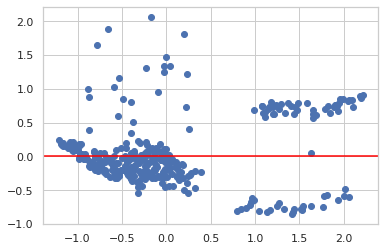

In [92]:
# restamos valores reales con los predichos. Damos formato adecuado
# a los valores predichos
residuals = np.subtract(y_test, y_pred.reshape(-1))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='Red', linestyle='-');

- Los valores se comparan con la linea del cero.
- La primer region indica que los valores predichos si se acercan a los valores reales.
- La segunda region indica que los valores predichos no son perfecto ya que estan un poco alejados del cero

## Segundo modelo
Estos resultados de arriba son buenos, pero se pueden mejorar. Intentaremos hacer algunas transformaciones sobre las variables que pueden ser de utilidad.

In [93]:
# creamos una nueva copia del dataframe
df_second =df.copy()

In [94]:
# creamos una nueva variable: Edad elevada al cuadrado
df_second['age2'] = df_second.age**2

# creamos una variable que considere el sobrepeso
df_second['sobrepeso'] = (df_second.bmi >= 30).astype(int)

# creamos una variable que combine el sobrepeso de una persona y su condicion de fumador
# ambas variables son un indicativo fuerte del incremento de los cargos medicos
df_second['sobrepeso_fumador'] = df_second.sobrepeso * df_second.smoker_yes

Creando el modelo

In [95]:
#----------------Seleccion de variables------------------------

# utiliza set para quitar las variables que no sean de interes

# variables predictoras 
X_cols = list(set(df_second.columns) - set(['charges']))

# variable objetivo
y_col = ['charges']

#----------------definimos las variables a utilizar en el modelo------------------------

# Variables predictoras
X=df_second[X_cols].values

# Variable objetivo
y = df_second[y_col].values

#---------------creamos dos conjuntos de datos: de prueba y de entrenamiento------------------

X_train, X_test, y_train, y_test = train_test_split(X,y)

# Estandarizamos los datos
sc_x = StandardScaler().fit(X)
sc_y = StandardScaler().fit(y)

X_train = sc_x.transform(X_train)
X_test = sc_x.transform(X_test)
y_train = sc_y.transform(y_train)
y_test = sc_y.transform(y_test)

#----------------------creamos el modelo---------------------
model = LinearRegression()

# ajustamos el modelos a los datos de entrenamiento
model.fit(X_train, y_train)

# generamos una prediccion con los datos de prueba
y_pred = model.predict(X_test)

# mostramos cantidad de predicciones y numero de registros
y_pred.shape


(333, 1)

Analizando el segundo modelo

In [96]:
# evaluando las metricas de los valores reales con los valores predichos

# Error cuadratico medio
mse = metrics.mean_squared_error(y_test, y_pred)

# R cuadrado
r2 = metrics.r2_score(y_test, y_pred)

# mostramos resultados
print('R Cuadrado: ',r2.round(4))
print('MSE: ',mse.round(4))

R Cuadrado:  0.8627
MSE:  0.1535


In [97]:
# obtener solo el valor del intercepto
model.intercept_ = model.intercept_[0]

# obtener los coeficientes del modelo en el formato adecuado
model.coef_ = model.coef_.reshape(-1)

# damos formato adecuado a los datos de prueba
y_test = y_test.reshape(-1)

# mostramos resultados
print('======Summary========')

# se pasa el modelo con los datos de prueba y el nombre de las columnas(X_cols)
stats.summary(model, X_test, y_test, X_cols)


======Summary========
Residuals:
   Min     1Q  Median   3Q    Max
-1.969 0.0247  0.0922 0.14 1.4204


Coefficients:
                   Estimate  Std. Error  t value   p value
_intercept        -0.004841    0.021628  -0.2238  0.823036
children           0.074446    0.019940   3.7334  0.000222
sobrepeso         -0.058826    0.033141  -1.7750  0.076813
region_southwest  -0.050618    0.025156  -2.0122  0.045009
smoker_yes         0.453530    0.028080  16.1515  0.000000
age2               0.375591    0.112202   3.3475  0.000909
region_southeast  -0.035803    0.025603  -1.3984  0.162923
region_northwest  -0.024297    0.025949  -0.9363  0.349795
age               -0.058984    0.111964  -0.5268  0.598677
sobrepeso_fumador  0.505238    0.028792  17.5481  0.000000
bmi                0.065994    0.032262   2.0455  0.041589
sex_male          -0.001236    0.021819  -0.0566  0.954868
---
R-squared:  0.86265,    Adjusted R-squared:  0.85795
F-statistic: 183.29 on 11 features


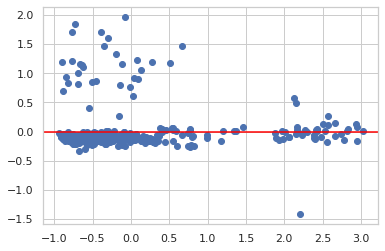

In [98]:
# restamos valores reales con los predichos. Damos formato adecuado
# a los valores predichos
residuals = np.subtract(y_test, y_pred.reshape(-1))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='Red', linestyle='-');

Verifiquemos la relacion lineal entre un paciente con sobrepeso y fumador con los cargos medicos

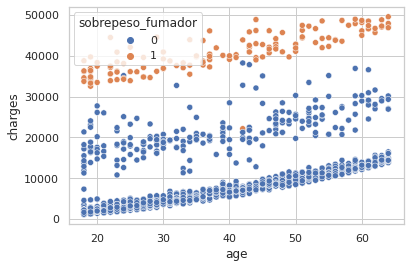

In [99]:
sns.scatterplot(data=df_second, x='age', y='charges', hue='sobrepeso_fumador');

## Tercer Modelo

Cuales son las variables que puedes dejar para este modelo?

Para ello, analizamos el p-valor y eliminamos todas aquellas mayores a .05. La razon es una funcionalidad estadistica donde el valor indica si la variable es verdaderamente cero o no cumple dicha suposicion y es diferente a cero.

In [100]:
#----------------Seleccion de variables------------------------

# variables predictoras 
X_cols = ['region_southwest','sobrepeso_fumador','smoker_yes','age2','children']

# variable objetivo
y_col = ['charges']

#----------------definimos las variables a utilizar en el modelo------------------------

# Variables predictoras
X=df_second[X_cols].values

# Variable objetivo
y = df_second[y_col].values

#---------------creamos dos conjuntos de datos: de prueba y de entrenamiento------------------

X_train, X_test, y_train, y_test = train_test_split(X,y)

# Estandarizamos los datos
sc_x = StandardScaler().fit(X)
sc_y = StandardScaler().fit(y)

X_train = sc_x.transform(X_train)
X_test = sc_x.transform(X_test)
y_train = sc_y.transform(y_train)
y_test = sc_y.transform(y_test)

#----------------------creamos el modelo---------------------
model = LinearRegression()

# ajustamos el modelos a los datos de entrenamiento
model.fit(X_train, y_train)

# generamos una prediccion con los datos de prueba
y_pred = model.predict(X_test)

# mostramos cantidad de predicciones y numero de registros
y_pred.shape


(333, 1)

In [101]:
# evaluando las metricas de los valores reales con los valores predichos

# Error cuadratico medio
mse = metrics.mean_squared_error(y_test, y_pred)

# R cuadrado
r2 = metrics.r2_score(y_test, y_pred)

# mostramos resultados
print('R Cuadrado: ',r2.round(4))
print('MSE: ',mse.round(4))

R Cuadrado:  0.8755
MSE:  0.1108


In [102]:
# obtener solo el valor del intercepto
model.intercept_ = model.intercept_[0]

# obtener los coeficientes del modelo en el formato adecuado
model.coef_ = model.coef_.reshape(-1)

# damos formato adecuado a los datos de prueba
y_test = y_test.reshape(-1)

# mostramos resultados
print('======Summary========')

# se pasa el modelo con los datos de prueba y el nombre de las columnas(X_cols)
stats.summary(model, X_test, y_test, X_cols)


======Summary========
Residuals:
    Min    1Q  Median     3Q    Max
-1.7377 0.075  0.1117 0.1409 0.2038


Coefficients:
                   Estimate  Std. Error  t value   p value
_intercept         0.002729    0.018418   0.1482  0.882299
region_southwest  -0.028807    0.018126  -1.5893  0.112948
sobrepeso_fumador  0.503504    0.026846  18.7551  0.000000
smoker_yes         0.442752    0.027701  15.9833  0.000000
age2               0.321946    0.018871  17.0600  0.000000
children           0.067549    0.018523   3.6467  0.000308
---
R-squared:  0.87552,    Adjusted R-squared:  0.87361
F-statistic: 459.98 on 5 features


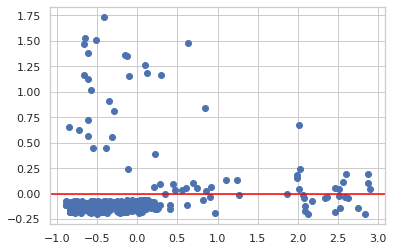

In [103]:
# restamos valores reales con los predichos. Damos formato adecuado
# a los valores predichos
residuals = np.subtract(y_test, y_pred.reshape(-1))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='Red', linestyle='-');

## Ajuste del Tercer Modelo

Del summary anterior, vemos que las variables region_southwest e intercept no estan contribuyendo de forma relevante al modelo por lo que eliminamos ambas variables para ajustar aun mas el modelo

In [104]:
#----------------Seleccion de variables------------------------

# variables predictoras 
X_cols = ['sobrepeso_fumador','smoker_yes','age2','children']

# variable objetivo
y_col = ['charges']

#----------------definimos las variables a utilizar en el modelo------------------------

# Variables predictoras
X=df_second[X_cols].values

# Variable objetivo
y = df_second[y_col].values

#---------------creamos dos conjuntos de datos: de prueba y de entrenamiento------------------

X_train, X_test, y_train, y_test = train_test_split(X,y)

# Estandarizamos los datos
sc_x = StandardScaler().fit(X)
sc_y = StandardScaler().fit(y)

X_train = sc_x.transform(X_train)
X_test = sc_x.transform(X_test)
y_train = sc_y.transform(y_train)
y_test = sc_y.transform(y_test)

#----------------------creamos el modelo---------------------

# modificamos el parametro del intercepto como falso
model = LinearRegression(fit_intercept=False)

# ajustamos el modelos a los datos de entrenamiento
model.fit(X_train, y_train)

# generamos una prediccion con los datos de prueba
y_pred = model.predict(X_test)

# mostramos cantidad de predicciones y numero de registros
y_pred.shape


(333, 1)

In [105]:
# evaluando las metricas de los valores reales con los valores predichos

# Error cuadratico medio
mse = metrics.mean_squared_error(y_test, y_pred)

# R cuadrado
r2 = metrics.r2_score(y_test, y_pred)

# mostramos resultados
print('R Cuadrado: ',r2.round(4))
print('MSE: ',mse.round(4))

R Cuadrado:  0.8698
MSE:  0.1247


In [106]:
# omitimos este analisis debido a que no tenemos el intercepto
#model.intercept_ = model.intercept_[0]

# obtener los coeficientes del modelo en el formato adecuado
model.coef_ = model.coef_.reshape(-1)

# damos formato adecuado a los datos de prueba
y_test = y_test.reshape(-1)

# mostramos resultados
print('======Summary========')

# se pasa el modelo con los datos de prueba y el nombre de las columnas(X_cols)
stats.summary(model, X_test, y_test, X_cols)


======Summary========
Residuals:
    Min     1Q  Median     3Q    Max
-2.0386 0.0665  0.1091 0.1448 0.4272


Coefficients:
                   Estimate  Std. Error  t value   p value
_intercept         0.000000    0.019393   0.0000  1.000000
sobrepeso_fumador  0.491961    0.026164  18.8032  0.000000
smoker_yes         0.461393    0.025797  17.8856  0.000000
age2               0.319473    0.018812  16.9827  0.000000
children           0.074184    0.018342   4.0445  0.000065
---
R-squared:  0.86976,    Adjusted R-squared:  0.86817
F-statistic: 547.59 on 4 features


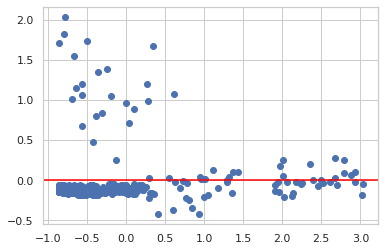

In [107]:
# restamos valores reales con los predichos. Damos formato adecuado
# a los valores predichos
residuals = np.subtract(y_test, y_pred.reshape(-1))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='Red', linestyle='-');